In [6]:
import numpy as np
np.set_printoptions(precision=3,suppress=True)
import cv2
import glob
import os
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
%matplotlib inline

class Camera_Alignment:
    def DLT(self, point1, point2):
        P1 = self.Ps[0]
        P2 = self.Ps[1]
        A = [point1[1]*P1[2,:] - P1[1,:],
             P1[0,:] - point1[0]*P1[2,:],
             point2[1]*P2[2,:] - P2[1,:],
             P2[0,:] - point2[0]*P2[2,:]
            ]
        A = np.array(A).reshape((4,4))
        B = A.transpose() @ A
        from scipy import linalg
        U, s, Vh = linalg.svd(B, full_matrices = False)
        return Vh[3,0:3]/Vh[3,3]
    
        
    def __init__(self,pathtodata):
        """
        pathtodata: should be path to folder containing calibration images, e.g. "~/seeds/250305/calibration"
        """
        image_fns = sorted(glob.glob(os.path.join(pathtodata,'*.tiff')))
 
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        objpoints = [[],[]]
        imgpoints = [[],[]]
        self.test_imgpoints = [[],[]]
        imgshape = [None,None]
        print("Calibration: %d images available" % len(image_fns))
        
        for imgindex,fname in enumerate(image_fns):
            objp = []
            for i in range(11):
                for j in range(5):
                    objp.append([j+(i%2)/2,i,0])
                    #objp.append([(i+((j+1)%2)/2),j/2,0])
            objp = np.array(objp).astype(np.float32)
            img = cv2.imread(fname)
            greyscaleimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            imgs = [greyscaleimg[:,:1224],greyscaleimg[:,1224:][:,-1::-1]]
            for cami,img in enumerate(imgs):
                isFound, circle_locations = cv2.findCirclesGrid(img, (5,11), flags = cv2.CALIB_CB_ASYMMETRIC_GRID + cv2.CALIB_CB_CLUSTERING)
                if imgindex<5:#len(image_fns):
                    self.test_imgpoints[cami].append(circle_locations)
                else:
                    objpoints[cami].append(objp.copy())
                    imgpoints[cami].append(circle_locations)
                    imgshape[cami] = img.shape
            #if imgindex==40:
            #    plt.figure()
            #    plt.imshow(img,cmap='gray')
            #    plt.plot(circle_locations[:,0,0],circle_locations[:,0,1],'+')
                
        
        mtxs = []
        dists = []
        print("2d calibration...")
        for i in range(2):
            print("CAMERA %d" % i)
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints[i], imgpoints[i], imgshape[i], None, None)
            mtxs.append(mtx)
            dists.append(dist)
            print('rmse:', ret)
        
        stereocalibration_flags = cv2.CALIB_FIX_INTRINSIC
        ret, CM1, dist1, CM2, dist2, R, T, E, F = cv2.stereoCalibrate(objpoints[0], imgpoints[0], imgpoints[1], mtxs[0], dists[0], mtxs[1], dists[1], imgshape[0], criteria = criteria, flags = stereocalibration_flags)
        
        RTs = []
        RTs.append(np.concatenate([np.eye(3), [[0],[0],[0]]], axis = -1))
        RTs.append(np.concatenate([R, T], axis = -1))
        self.Ps = []
        for mtx,RT in zip(mtxs,RTs):
            self.Ps.append(mtx @ RT)

    def get_coordinates(self,imgpoints1,imgpoints2):
        if np.isscalar(imgpoints1[0]): return self.DLT(imgpoints1,imgpoints2)
        
        coords = []
        for p1,p2 in zip(imgpoints1,imgpoints2):
            coords.append(self.DLT(p1,p2))
        return np.array(coords)

    def check_tests(self):
        """
        Some calibration images were left out, this checks if the dots are correct distance apart
        Returns mean percentage error, in percent.
        """
        checks =[]
        for test in zip(self.test_imgpoints[0],self.test_imgpoints[1]):
            world = []
            
            world = self.get_coordinates(test[0][:,0,:],test[1][:,0,:])
            v = world[0,:]-world[1+np.argmin(np.sum((world[0,:]-world[1:,:])**2,1)),:]
            distances= np.diag(np.sqrt(np.sum(((world[:,:,None]-world[:,:,None].T)**2),1)),1)
            avgdist = np.mean(np.array([distances[i:(i+4)] for i in range(0,len(distances),5)]))
            checks.append(avgdist)
        
        return 100*np.mean(np.abs(np.array(checks)-1))

In [7]:
cam_alignment = Camera_Alignment('/home/mike/Documents/Research/seed_data/250305/calibration')

Calibration: 50 images available
2d calibration...
CAMERA 0
rmse: 0.2760905185986385
CAMERA 1
rmse: 0.2838263658438121


In [8]:
cam_alignment.check_tests()

1.5873661243043946

In [9]:
def get_seed_2d_coordinates(image_fns,save_debug_images = 10,smooth=2):
    """
    
    """
    if save_debug_images is not None:
        plt.figure(figsize=[5,2*len(image_fns)/save_debug_images])
    lastimg = None
    results = []
    for imgindex,fname in enumerate(image_fns):
        img_indexid = int(os.path.split(fname)[-1][-9:-5])
        img = cv2.imread(fname)
        greyscaleimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(float)
        if smooth is not None:
            greyscaleimg = ndimage.gaussian_filter(greyscaleimg, sigma=(smooth, smooth), order=0)
        
        if lastimg is not None:
            diff_greyscaleimg = greyscaleimg - lastimg
            diff_imgs = [diff_greyscaleimg[:,:1224],diff_greyscaleimg[:,1224:][:,-1::-1]]
            coords = []
            for diff_img in diff_imgs:
                coords.append(np.unravel_index(diff_img.argmax(), diff_img.shape))
            #print(str(np.max(diff_imgs[0]))+' '+str(np.max(diff_imgs[1]))+str(coords))
            results.append([img_indexid,np.max(diff_imgs[0]),np.max(diff_imgs[1]),coords[0],coords[1]])
            if save_debug_images is not None:
                if imgindex%save_debug_images==0:
                    for imgpairi in range(2):
                        plt.subplot(int(1+len(image_fns)/save_debug_images),2,int(2*(imgindex/save_debug_images)+imgpairi+1))
                        plt.imshow(diff_imgs[imgpairi][max(coords[imgpairi][0]-100,0):min(coords[imgpairi][0]+100,2047),max(coords[imgpairi][1]-100,0):min(coords[imgpairi][1]+100,1223)])
                        plt.clim([0,np.max(diff_imgs[imgpairi])])
                        plt.vlines([100,100],[25,125],[75,175],'w')
                        plt.hlines([100,100],[25,125],[75,175],'w')
                        plt.xticks([])
                        plt.yticks([])
                        if imgpairi==0: plt.title("%0.1f %0.1f " % (np.max(diff_imgs[0]),np.max(diff_imgs[1]))+str(coords))
        lastimg = greyscaleimg
    if save_debug_images:
        path_to_data, _ = os.path.split(image_fns[0])
        plt.savefig(os.path.join(path_to_data,'debug.pdf'))
    return results

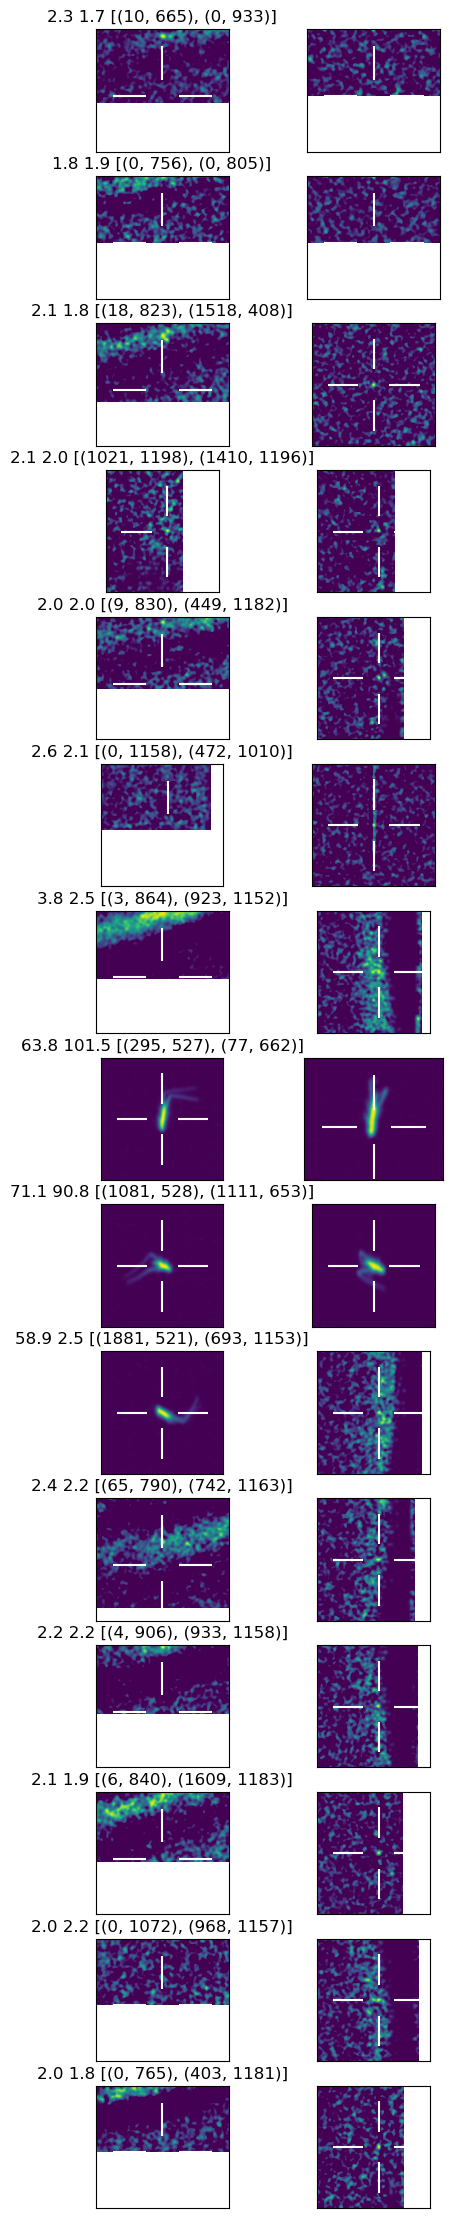

In [10]:
def get_seedpath(pathtodata):
    image_fns = sorted(glob.glob(os.path.join(pathtodata,'*.tiff')))
    results = get_seed_2d_coordinates(image_fns)
    
    seedpath = []
    for r in results:
        if (r[1]<10) or (r[2]<10):
            continue
        seedpath.append([r[0]]+cam_alignment.get_coordinates(r[3],r[4]).tolist())
    return seedpath
r = get_seedpath('/home/mike/Documents/Research/seed_data/250305/Afatua_t1')

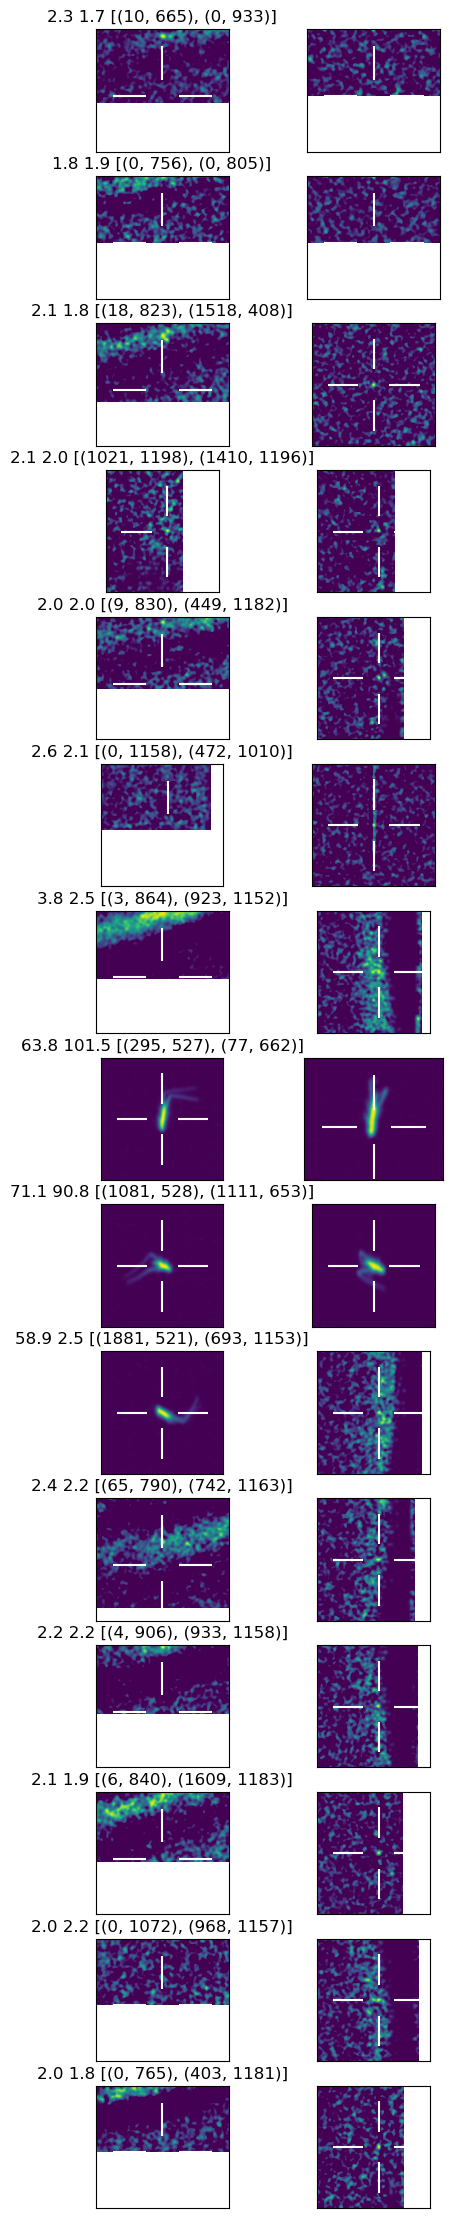

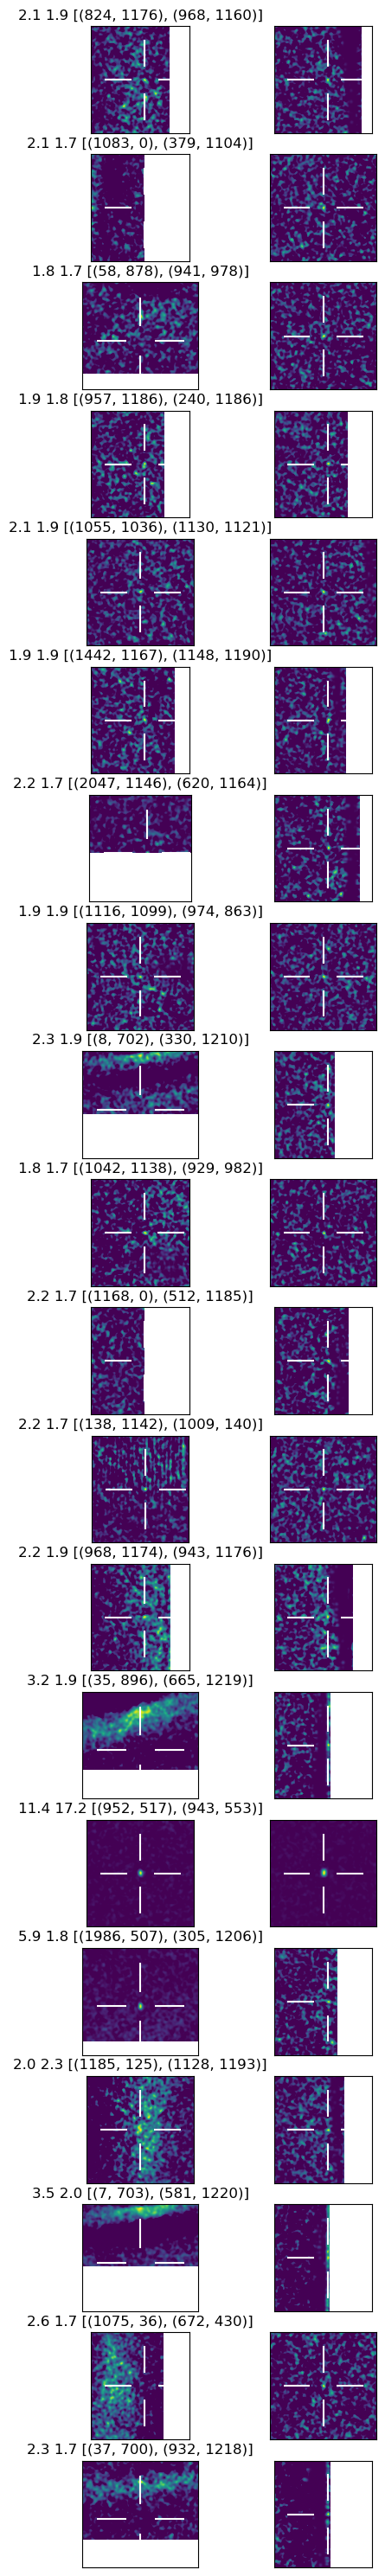

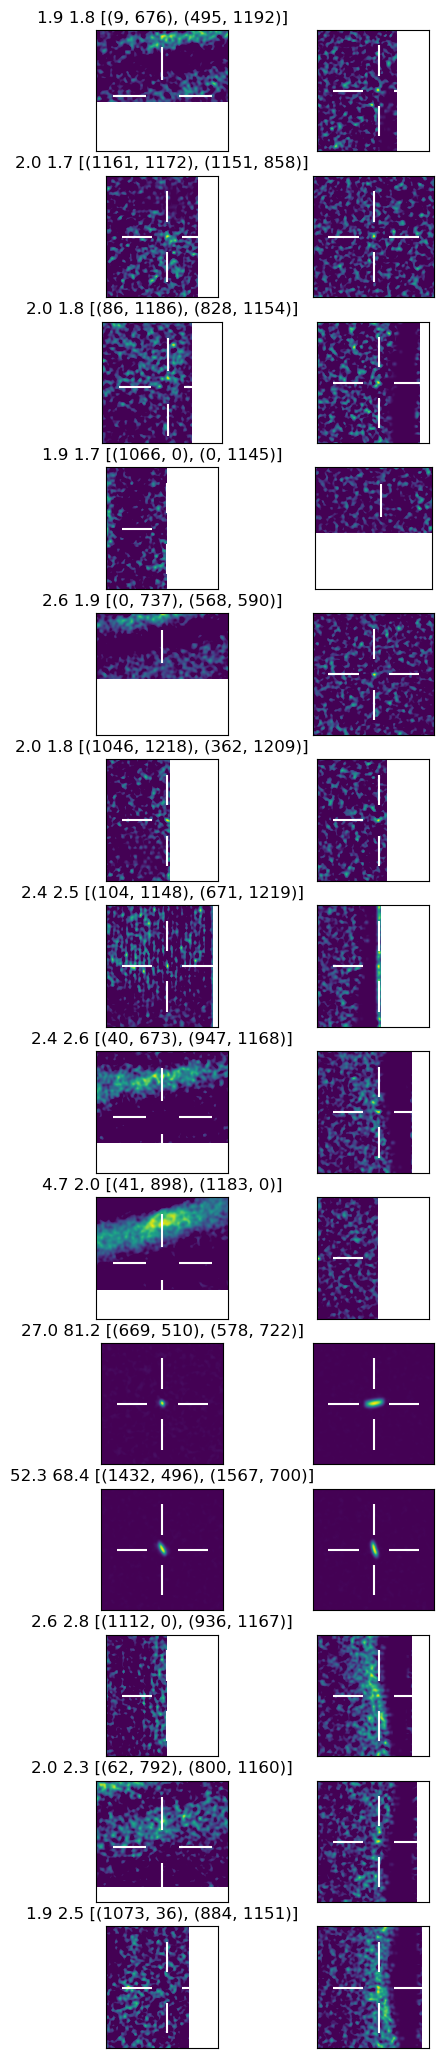

In [13]:
seedps = []
for datapath in ['/home/mike/Documents/Research/seed_data/250305/Afatua_t1','/home/mike/Documents/Research/seed_data/250305/caryopsis_t1','/home/mike/Documents/Research/seed_data/250305/Gfluitans_t1/']:
    seedps.append(get_seedpath(datapath))

In [17]:
seedp[:,1]

TypeError: list indices must be integers or slices, not tuple

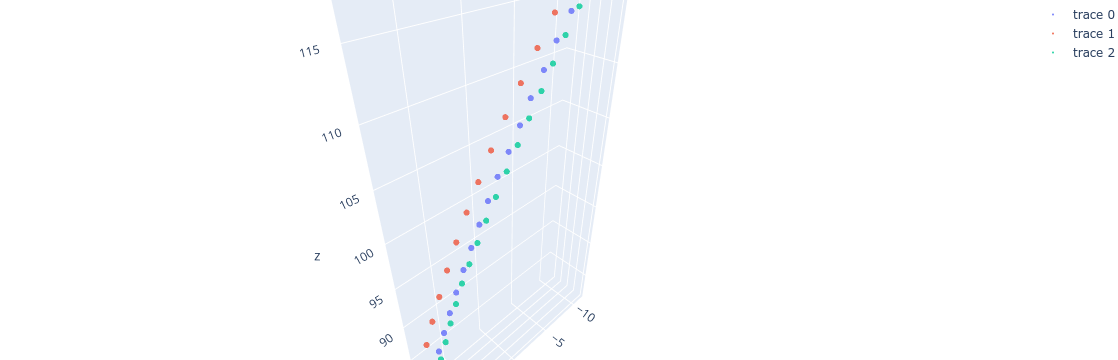

In [29]:
# Import dependencies
import plotly
import plotly.graph_objs as go

# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()
data = []
for seedp in seedps:
    seedp = np.array(seedp)
    # Configure the trace.
    trace = go.Scatter3d(
        x=seedp[:,1],  # <-- Put your data instead
        y=seedp[:,2],  # <-- Put your data instead
        z=seedp[:,3],  # <-- Put your data instead
        mode='markers',
        marker={
            'size': 2,
            'opacity': 0.8,
        }
    )
    data.append(trace)

# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0},scene=dict(
                 aspectmode='data'
         )
)



plot_figure = go.Figure(data=data, layout=layout)

# Render the plot.
plotly.offline.iplot(plot_figure)

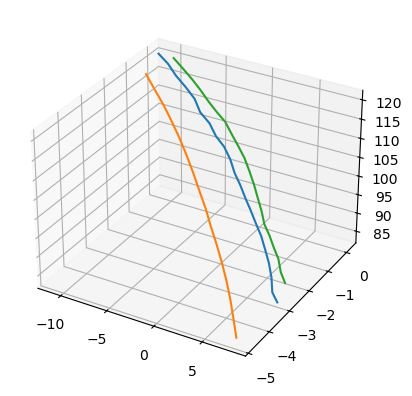

In [21]:
%matplotlib inline
ax = plt.figure().add_subplot(projection='3d')
for seedp in seedps:
    seedp = np.array(seedp)
    ax.plot(seedp[:,1], seedp[:,2], seedp[:,3])